# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [291]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

Признак N_Days исключён, поскольку он приводит к ликам. Это значение всегда указывается постфактум вместе с таргетом. Если наша цель — создание "честной" медицинской ML-модели, то на момент прогнозирования вероятности исхода заболевания мы ничего не знаем о том, сколько дней проживёт пациент.

# Вспомогателные функции для визуала

In [ ]:

# барплот важности признаков
def plot_feature_importances(gs, model_step_name, title=None, top_n=20):
    pipe = gs.best_estimator_
    preprocess = pipe.named_steps["preprocess"]
    model = pipe.named_steps[model_step_name]

    feature_names = preprocess.get_feature_names_out()

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_type = "feature_importances_"

    elif hasattr(model, "coef_"):
        importances = model.coef_[0]
        importance_type = "coef_"

    else:
        raise ValueError("Модель не поддерживает оценку важности признаков")

    df = (
        pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        })
        .assign(abs_importance=lambda x: x["importance"].abs())
        .sort_values("abs_importance", ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x="importance",
        y="feature",
        orient="h"
    )
    plt.title(title or f"Feature importance ({importance_type})")
    plt.tight_layout()
    plt.show()
    

# матрица ошибок
def plot_confusion_matrix_simple(y_true, y_pred, title="Матрица ошибок"):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
# кривые precision, recall, F1 в зависимости от порога
def plot_threshold_curves(estimator, X, y, cv, title="Зависимость метрик от порога"):

    if hasattr(estimator, "best_estimator_"):
        model = estimator.best_estimator_
    else:
        model = estimator

    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    thresholds = np.arange(0.1, 0.91, 0.05)
    recalls, precisions, f1s = [], [], []

    for thr in thresholds:
        y_thr = (y_proba >= thr).astype(int)
        recalls.append(recall_score(y, y_thr))
        precisions.append(precision_score(y, y_thr))
        f1s.append(f1_score(y, y_thr))

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Порог вероятности")
    plt.ylabel("Метрика")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def cross_val_predict_proba(gs,X_true, y_true, skf):
    y_pred_base = cross_val_predict(
    gs.best_estimator_,
    X_true, y_true,
    cv=skf,
    n_jobs=-1
    )

    print("Отчёт по классам:")
    print(classification_report(y_true, y_pred_base))

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [293]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [294]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL означает, что пациент выжил благодаря трансплантации печени. А информации о том, кому была сделана или назначена трансплантация, в данных нет. Поэтому мы не можем корректно предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних факторов (решение врача, наличие органа, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того, CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [295]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

Наблюдаем выраженный дисбаланс классов: только более трети пациентов страдают тяжёлой формой заболевания. Это будет учтено при обучении ML-модели и оценке качества.  

In [296]:
df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [297]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [298]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Напишем классы-преобразователи для переменных разных типов.

In [299]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_


class PercentileClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в указанных колонках по перцентилям."""
    def __init__(self, columns, lower=0.0, upper=99.5):
        self.columns = columns
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            low = np.percentile(X[col], self.lower)
            up = np.percentile(X[col], self.upper)
            self.bounds_[col] = (low, up)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns)
        for col, (low, up) in self.bounds_.items():
            X_df[col] = X_df[col].clip(low, up)
        return X_df.values
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns, dtype=object)
        return np.asarray(input_features, dtype=object)

Создадим несколько пайплайнов с разными видами преобразований, из которых затем выберем лучший.

Ниже указаны четыре стратегии предобработки числовых признаков, которые имеют скошенное распределение с выбросами:

- Вариант 1: log + standard scaler
- Вариант 2: log + percentile clip + standard scaler
- Вариант 3: log + robust scaler
- Вариант 4: log + percentile clip + robust scaler

**Log-преобразование** стабилизирует дисперсию и уменьшает асимметрию, делает данные более нормальными.

**Percentile Clipper** обрезает экстремальные выбросы по перцентилям (в нашем случае — длинные правые хвосты), защищает от сильного влияния аномалий.

**Standard Scaler** стандартизует данные (среднее=0, дисперсия=1), хорошо подходит для нормально распределённых данных.

**Robust Scaler** масштабирует на основе медианы и межквартильного расстояния, более устойчив к выбросам.

In [300]:
def _engineered_pipe(strategy):
    if strategy == "standard":
        return Pipeline([
            ("scale", StandardScaler())
        ])
    elif strategy == "robust":
        return Pipeline([
            ("scale", RobustScaler())
        ])
    else:
        raise ValueError(f"Unknown engineered strategy: {strategy}")


In [301]:
def make_preprocessor(
    strategy="log_standard",
    engineered_features=False,
    engineered_strategy="standard"
):
    log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

    # -------- числовые пайплайны --------
    if strategy == "log_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", StandardScaler())
        ])

    elif strategy == "log_clip_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=99)),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", StandardScaler())
        ])

    elif strategy == "log_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", RobustScaler())
        ])

    elif strategy == "log_clip_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=99)),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([
            ("scale", RobustScaler())
        ])
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # -------- список трансформеров --------
    transformers = [
        ("num_skewed", skewed_pipe, skewed_numeric),
        ("num_symmetric", symmetric_pipe, symmetric_numeric),
        ("binary", BinaryMapper(binary_maps), binary_features),
        ("category", OneHotEncoder(
            drop="first",
            sparse_output=False
        ), multi_category_features),
    ]

    # -------- engineered features (УСЛОВНО) --------
    if engineered_features:
        transformers.append(
            (
                "engineered",
                _engineered_pipe(engineered_strategy),
                engineered_features
            )
        )

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        verbose_feature_names_out=False
    )

    return preprocessor


Применим разные стратегии преобразования к X_train, чтобы затем сравнить их между собой.

In [302]:
STRATEGIES = ["log_standard", "log_clip_standard", "log_robust", "log_clip_robust"]

def apply_strategies(X_train, strategies=STRATEGIES):
    outputs = {}
    for s in strategies:
        processor = make_preprocessor(s)
        X_proc = processor.fit_transform(X_train)
        cols = processor.get_feature_names_out()
        outputs[s] = pd.DataFrame(X_proc, columns=cols, index=X_train.index)
    return outputs

In [303]:
processed = apply_strategies(X_train)

Теперь выберем наиболее подходящий метод с помощью визуализаций.

In [304]:
def plot_skewed_changes(X_train, processed, features=skewed_numeric, bins=30):
    """
    Для каждого skewed признака:
    - слева оригинал
    - справа - версии после разных стратегий
    """
    n = len(features)
    fig, axes = plt.subplots(n, 1 + len(processed), figsize=(5*(1+len(processed)), 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax)
        ax.set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            ax = axes[i, j]
            sns.histplot(processed[s][col], bins=bins, ax=ax)
            ax.set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
    

def plot_symmetric_changes(X_train, X_processed, features=symmetric_numeric, bins=30):
    """
    Для каждого symmetric признака:
    - слева оригинал
    - справа - распределение после выбранной стратегии (standard или robust)
    """
    n = len(features)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax, color='steelblue', alpha=0.7)
        ax.set_title(f"{col} (до)")
        
    for i, col in enumerate(features):
        ax = axes[i, 1]
        sns.histplot(X_processed[col], bins=bins, ax=ax, color='steelblue', alpha=0.7)
        ax.set_title(f"{col} (после)")    

    plt.tight_layout()
    plt.show()    
    
    
def plot_boxplots(X_train, processed, features=skewed_numeric):
    n = len(features)
    fig, axes = plt.subplots(n, 1+len(processed), figsize=(5*(1+len(processed)), 2.5*n), squeeze=False)

    for i, col in enumerate(features):
        axes[i, 0].boxplot(X_train[col], vert=True)
        axes[i, 0].set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            axes[i, j].boxplot(processed[s][col].dropna(), vert=True)
            axes[i, j].set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
    
    
def summarize_changes(X_train, processed, numeric_features=numeric_features):
    print("\n=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===\n")

    for col in numeric_features:
        print(f"\nПРИЗНАК: {col}")
        print(f"  • исходный skew: {X_train[col].skew():.2f}")

        for strat, df_proc in processed.items():
            s = df_proc[col]
            skew = s.skew()
            z = (s - s.mean()) / (s.std() + 1e-9)
            out = (np.abs(z) > 3).mean()

            print(f"    - {strat}: skew={skew:.2f}, доля выбросов(|z|>3)={out:.3f}")
            

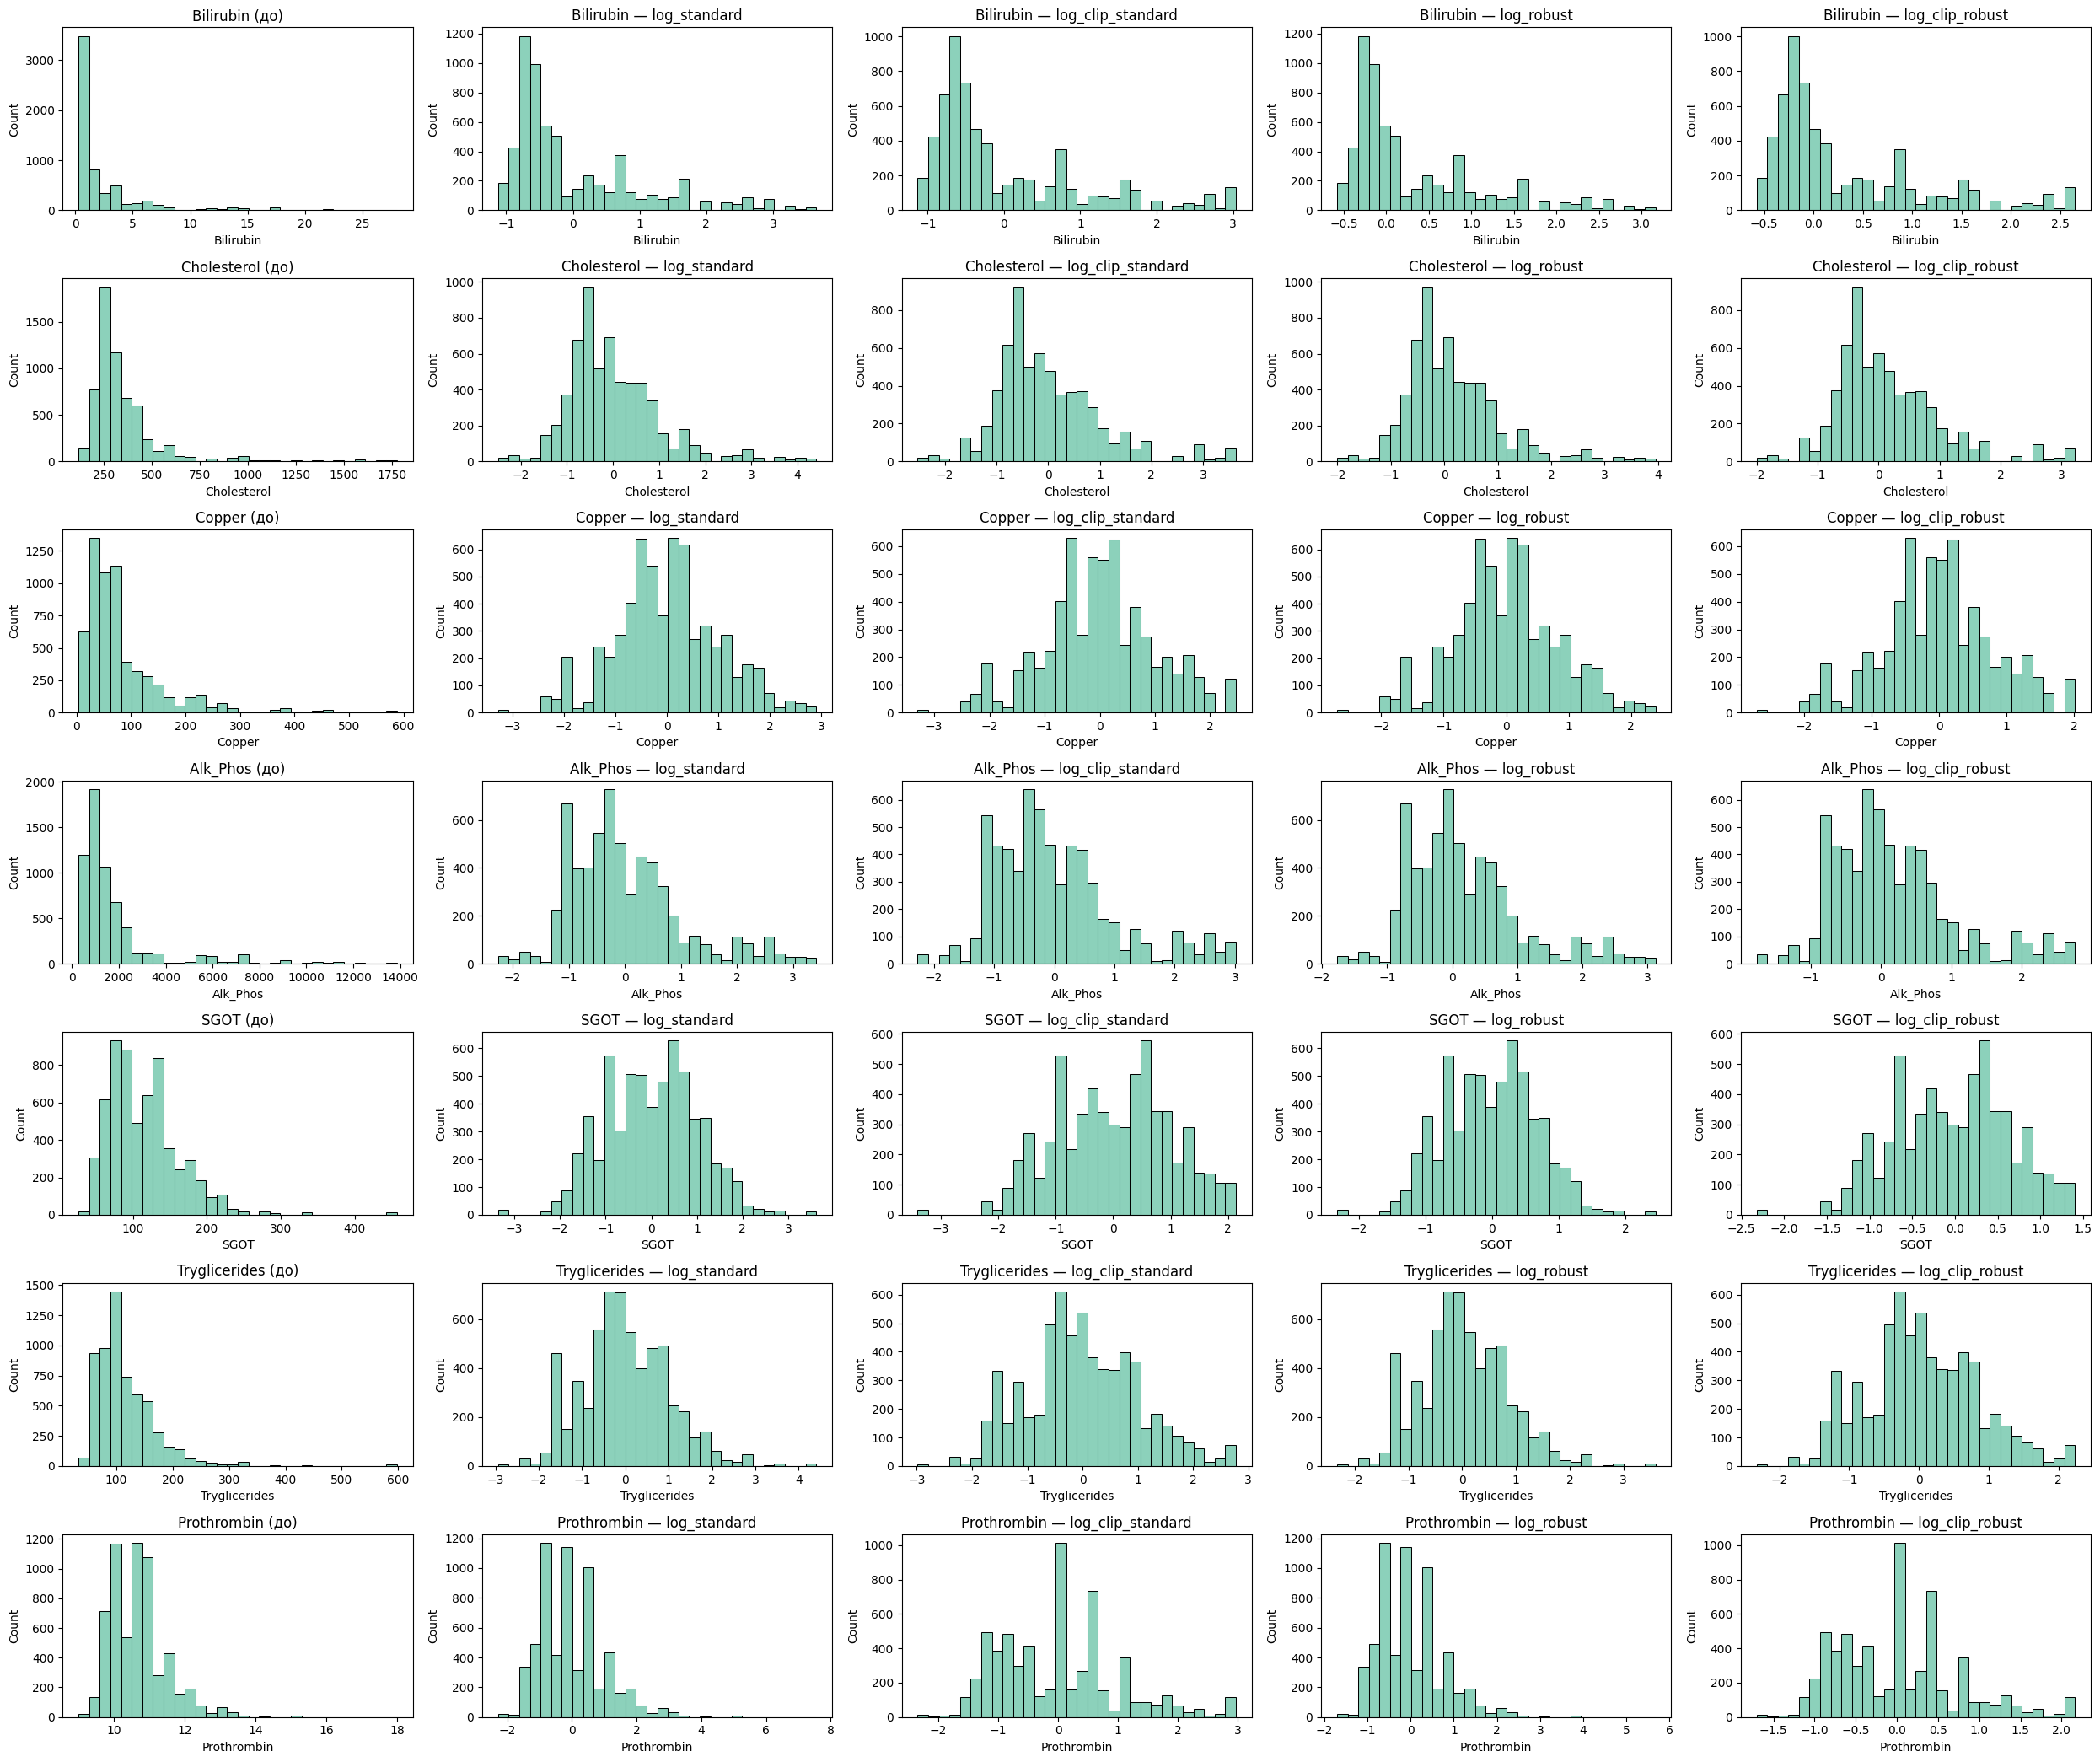

In [305]:
plot_skewed_changes(X_train, processed)

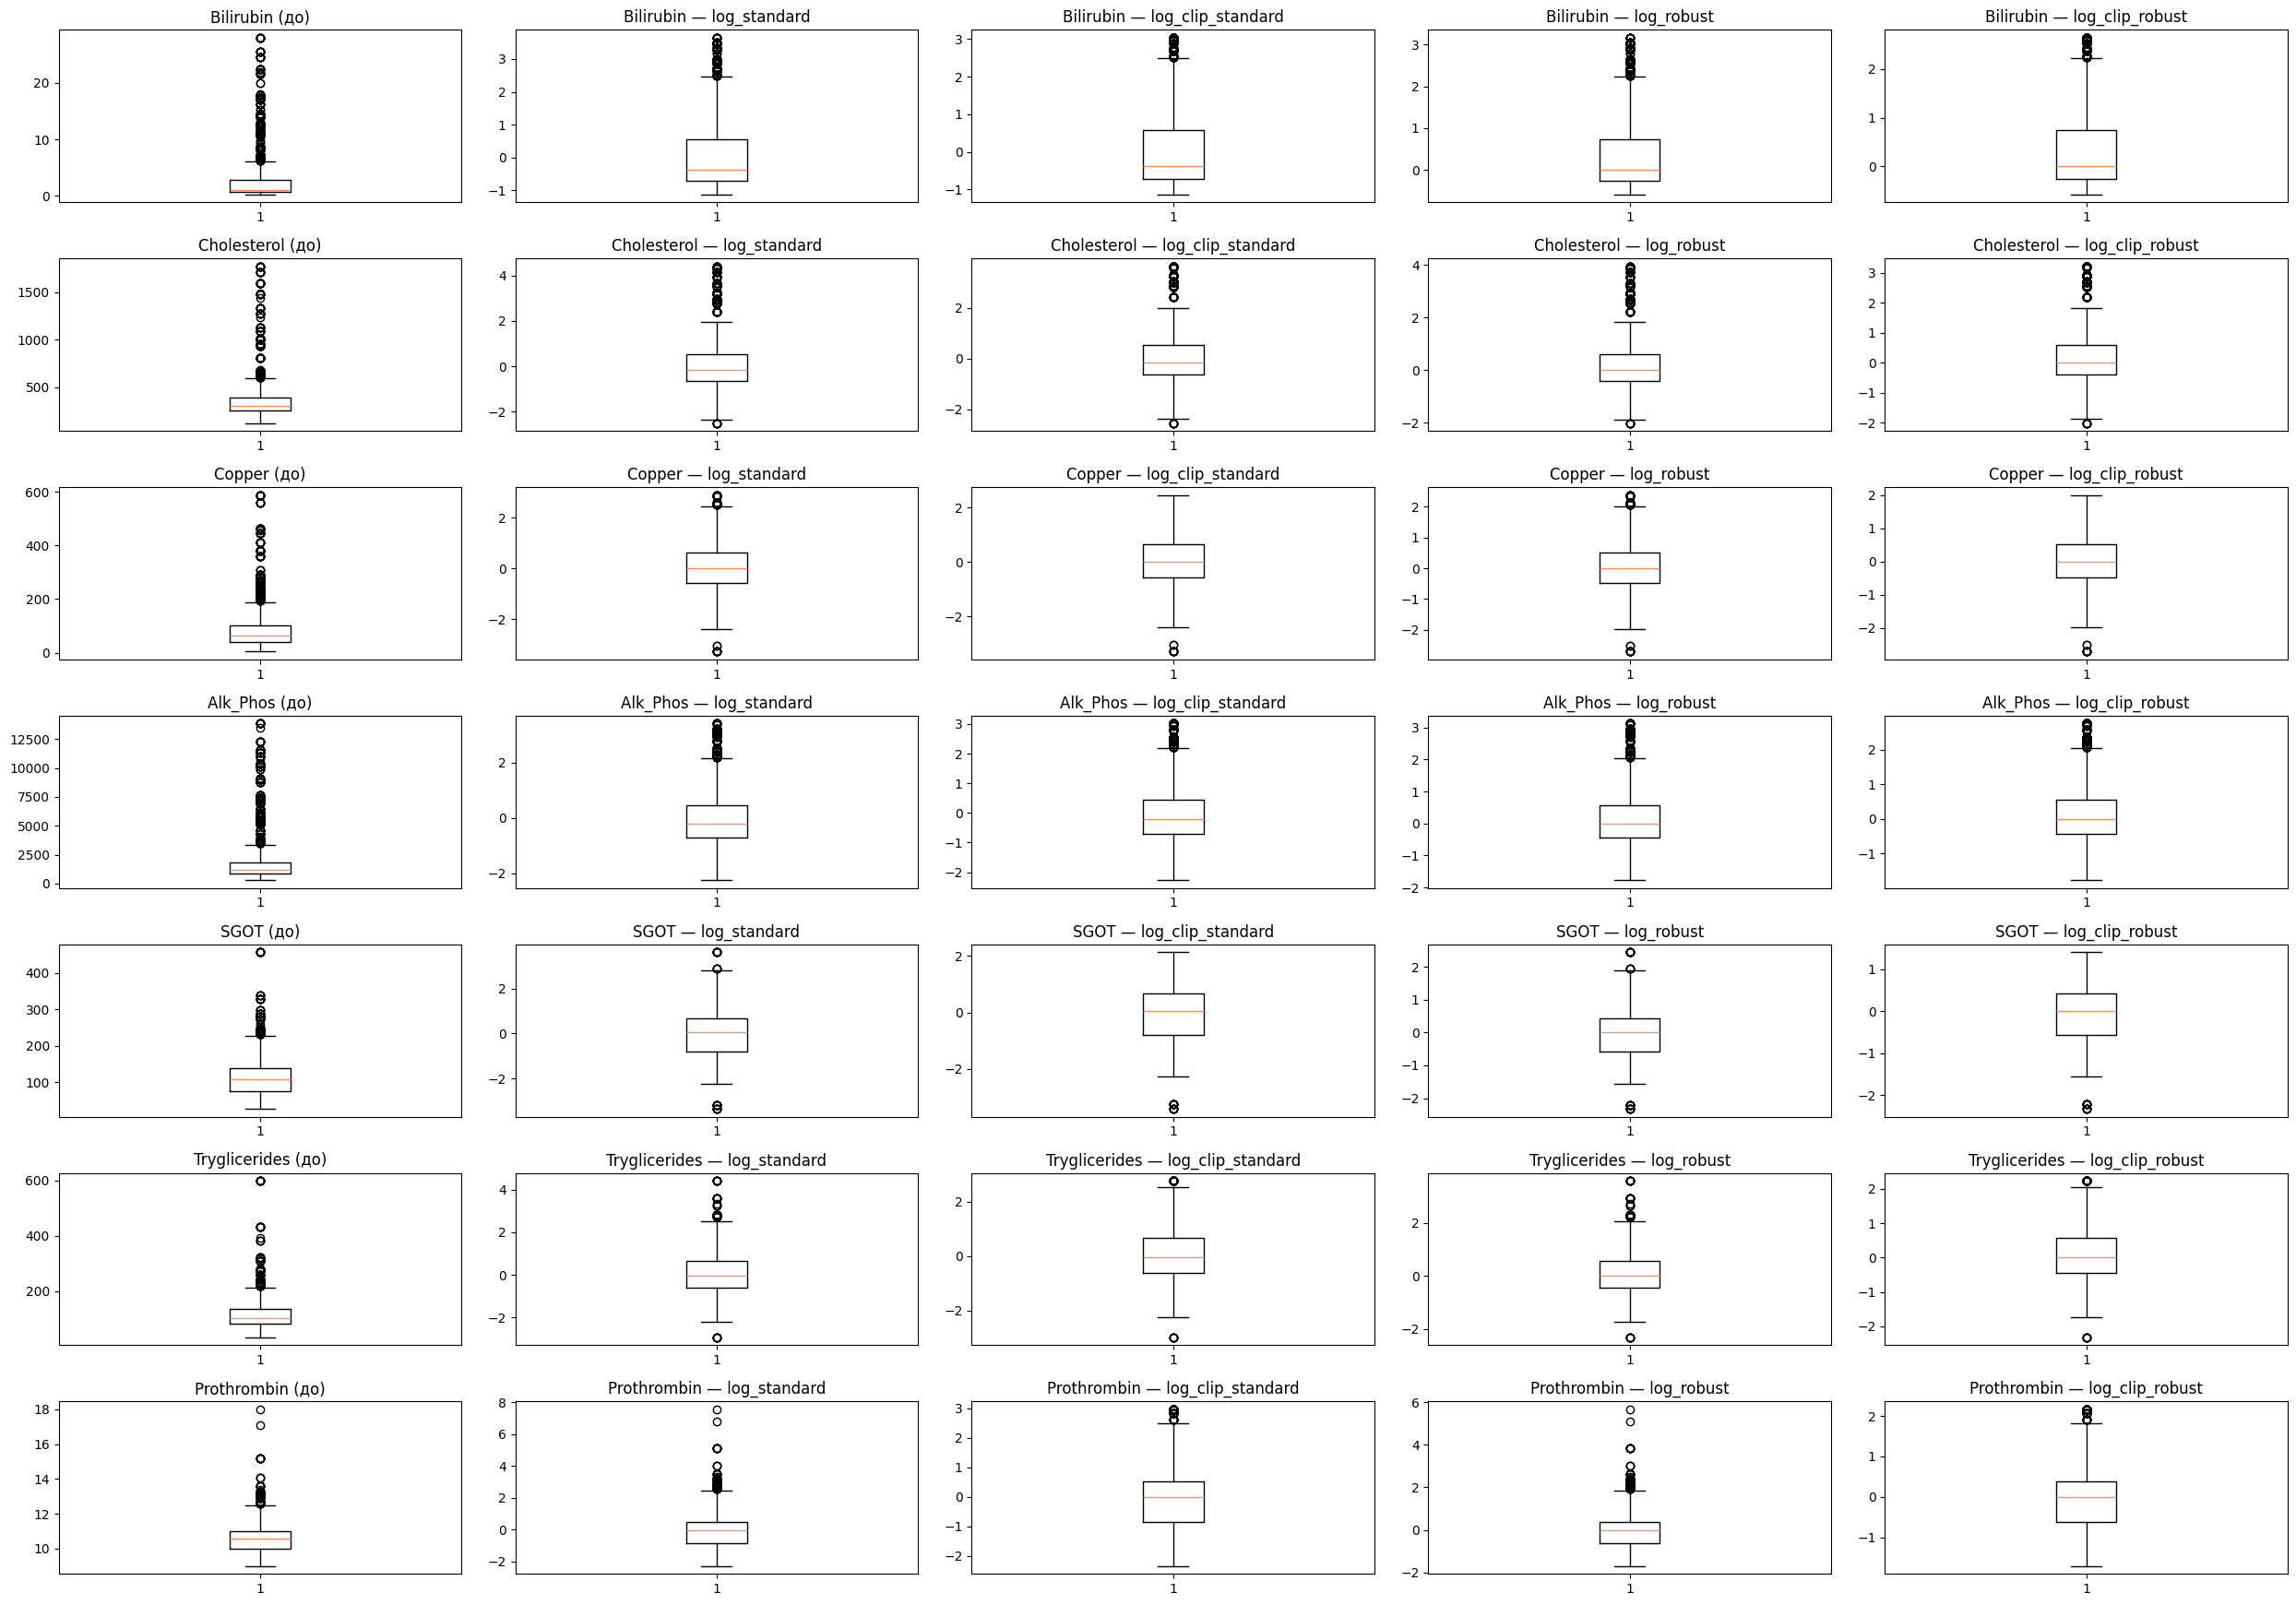

In [306]:
plot_boxplots(X_train, processed)

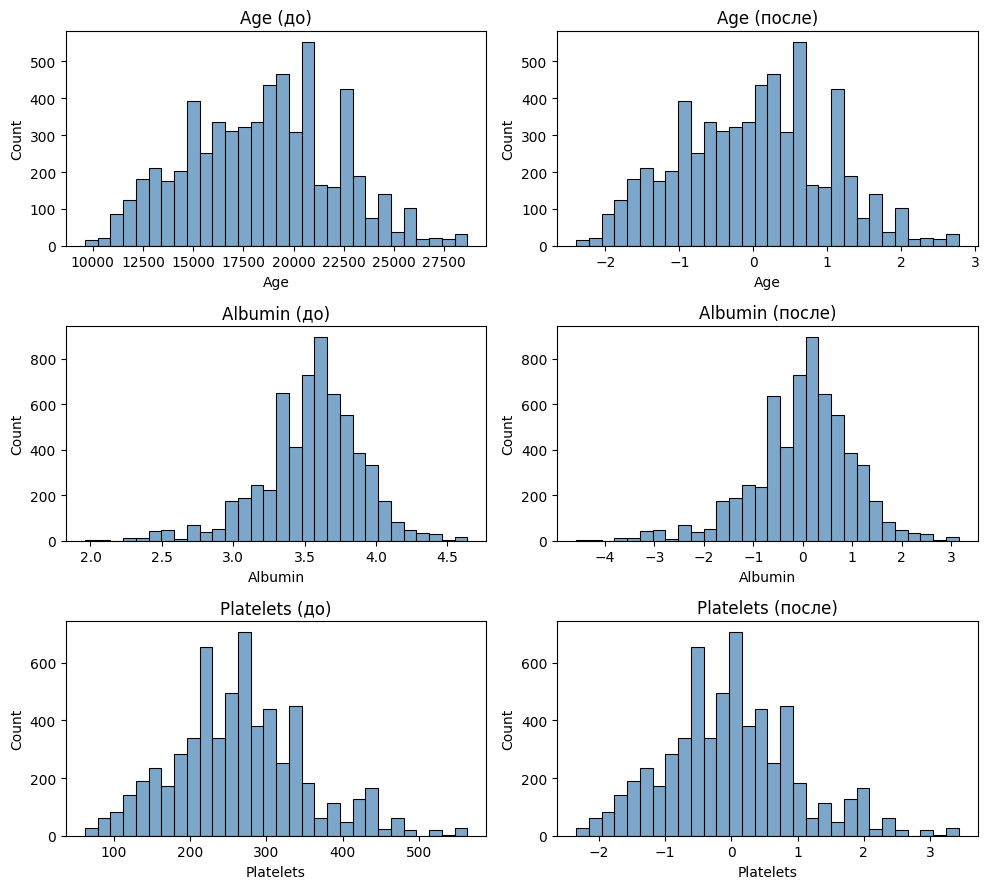

In [307]:
plot_symmetric_changes(X_train, processed["log_clip_standard"])

In [308]:
summarize_changes(X_train, processed)


=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===


ПРИЗНАК: Age
  • исходный skew: 0.07
    - log_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_robust: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_robust: skew=0.07, доля выбросов(|z|>3)=0.000

ПРИЗНАК: Bilirubin
  • исходный skew: 3.30
    - log_standard: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_standard: skew=1.38, доля выбросов(|z|>3)=0.012
    - log_robust: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_robust: skew=1.38, доля выбросов(|z|>3)=0.012

ПРИЗНАК: Cholesterol
  • исходный skew: 3.63
    - log_standard: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_standard: skew=1.12, доля выбросов(|z|>3)=0.017
    - log_robust: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_robust: skew=1.12, доля выбросов(|z|>3)=0.017

ПРИЗНАК: Albumin
  • исходный skew: -0.58
    - log_standard: skew=-0.58, доля выбросов(|z|>3)=0.015
    - 

Для числовых признаков выберем стратегию log_clip_standard: логарифмирование, мягкий клиппинг правого хвоста по 99-му перцентилю и последующая стандартизация. Логарифмирование снижает правую асимметрию признаков и "сжимает" длинные хвосты, клиппинг убирает единичные экстремальные значения, которые непропорционально влияют на оценку коэффициентов, а StandardScaler приводит все признаки к сопоставимому масштабу. В результате распределения становятся ближе к симметричным, доля выбросов снижается до долей процентов, что делает наши данные более подходящими для обучения и интерпретации логистической регрессии.

# Этап II. Применение логистической регрессии

Инициализируем выбранный метод предобработки.

In [309]:
preprocessor = make_preprocessor("log_clip_standard")

Посмотрим, как будет выглядеть предобработанный датасет после указанных выше преобразований.

In [310]:
df_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

In [311]:
df_proc.head()

,Bilirubin,Cholesterol,Copper,Alk_Phos,SGOT,Tryglicerides,Prothrombin,Age,Albumin,Platelets,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema_S,Edema_Y,Stage_2.0,Stage_3.0,Stage_4.0
0,0.365671,1.416713,0.817915,-0.049729,0.847200,0.831303,0.134652,-1.680801,0.151520,0.296398,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.808440,0.328017,-0.216828,-0.102753,0.899275,1.486451,-0.982436,0.021346,1.017782,-1.006539,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.995877,-1.554002,2.466007,-0.787794,1.389449,1.527506,2.965277,-0.377052,-2.302889,-0.868174,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2.525029,0.116510,0.430788,0.150109,0.627402,-0.070790,0.533971,-0.429158,0.151520,0.134972,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.638962,0.427694,0.664009,-0.471459,0.509857,-0.147094,0.664862,0.079423,0.555776,0.008138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [312]:
df_proc.describe().T

,count,mean,std,min,25%,50%,75%,max
Bilirubin,6104.0,-1.292108e-16,1.000082,-1.131869,-0.714008,-0.384863,0.579382,3.037639
Cholesterol,6104.0,-8.916706e-16,1.000082,-2.535609,-0.645027,-0.165635,0.537152,3.637798
Copper,6104.0,3.026558e-16,1.000082,-3.301729,-0.584547,0.009024,0.638636,2.466007
Alk_Phos,6104.0,-5.948351e-16,1.000082,-2.269281,-0.707868,-0.203528,0.459455,3.015599
SGOT,6104.0,1.070936e-16,1.000082,-3.405858,-0.802868,0.048940,0.684177,2.136337
Tryglicerides,6104.0,4.714446e-16,1.000082,-2.985370,-0.596702,-0.045843,0.666602,2.776406
Prothrombin,6104.0,-1.456240e-15,1.000082,-2.341653,-0.838396,-0.000733,0.533971,2.965277
Age,6104.0,-1.277557e-16,1.000082,-2.394281,-0.765137,0.081052,0.614330,2.776208
Albumin,6104.0,-8.291023e-16,1.000082,-4.584045,-0.570365,0.093769,0.642402,3.154562
Platelets,6104.0,2.165153e-16,1.000082,-2.344068,-0.614505,-0.003393,0.596189,3.432672


Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [313]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 1. Baseline

Логистическая регрессия с регуляризацией l2, с подобранными C и solver на кросс-валидации по recall.

### Обучаем модель

In [314]:
base_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga']
}

gs_base = GridSearchCV(
    base_pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_base.fit(X_train, y_train)
print("Базовая логрегрессия (без учёта дисбаланса)")
print("Лучшие параметры:", gs_base.best_params_)
print("Лучший recall на кросс-валидации:", gs_base.best_score_)

Базовая логрегрессия (без учёта дисбаланса)
Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Лучший recall на кросс-валидации: 0.6871513232399863


In [315]:
y_pred_base = cross_val_predict(
    gs_base.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (базовая модель без учёта дисбаланса):")
print(classification_report(y_train, y_pred_base))

Отчёт по классам (базовая модель без учёта дисбаланса):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3972
           1       0.80      0.69      0.74      2132

    accuracy                           0.83      6104
   macro avg       0.82      0.80      0.81      6104
weighted avg       0.83      0.83      0.83      6104



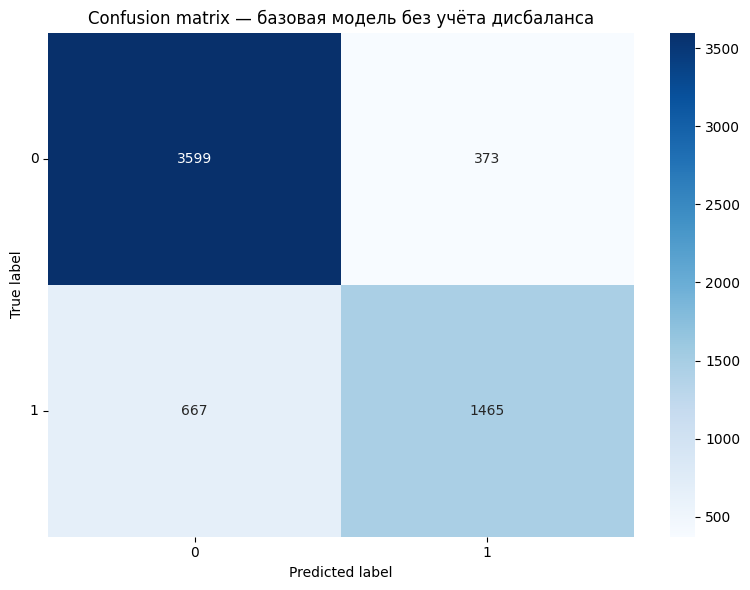

In [316]:
cm = confusion_matrix(y_train, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — базовая модель без учёта дисбаланса")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Видим, что:

Recall класса 1 = 0.69 => модель пропускает ~31% тяжёлых пациентов.

Precision класса 1 = 0.80 => ложноположительных относительно немного.

В целом модель "бережёт" класс 0, но недооценивает класс 1.

Вывод: хороший результат по precision, но слишком низкий recall для тяжёлых пациентов.

### Общий пайплайн

In [317]:
pipeline_combined = ImbPipeline([
    ("preprocess", preprocessor),
    ("sampler", "passthrough"), 
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_combined = {
    'sampler': [
        'passthrough',                                   
        RandomUnderSampler(random_state=RANDOM_STATE),   
        RandomOverSampler(random_state=RANDOM_STATE),    
        SMOTE(random_state=RANDOM_STATE, k_neighbors=5)  
    ],
    'logreg__C': [0.01, 0.05, 0.1, 0.2, 0.3],
    'logreg__l1_ratio': [0, 0.25, 0.5, 0.625, 0.75, 1],
    'logreg__penalty': ['elasticnet'],
    'logreg__solver': ['saga'],
    'logreg__class_weight': [None, 'balanced']
}

gs_combined = GridSearchCV(
    pipeline_combined,
    param_grid=param_grid_combined,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

gs_combined.fit(X_train, y_train)

print("\n" + "="*50)
print("Лучший результат общего пайплайна:")
print(f"Best params: {gs_combined.best_params_}")
print(f"Best Recall: {gs_combined.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Лучший результат общего пайплайна:
Best params: {'logreg__C': 0.2, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.75, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga', 'sampler': RandomUnderSampler(random_state=42)}
Best Recall: 0.7950


In [318]:
y_pred_combined = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам:")
print(classification_report(y_train, y_pred_combined))

Отчёт по классам:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



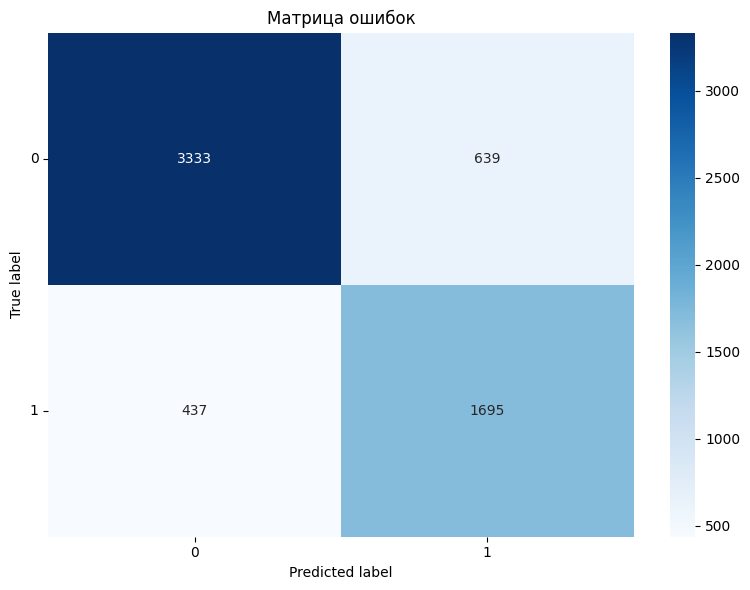

In [319]:
cm = confusion_matrix(y_train, y_pred_combined)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

### Промежуточный вывод

В контексте задачи лучше всего себя показал **общий пайплайн** (General Pipeline), подобравший комбинацию **RandomUnderSampler** и логистической регрессии с **ElasticNet** регуляризацией.

Почему:

- Лучший показатель Recall на кросс-валидации (**0.795**), что выше, чем у простого взвешивания классов (0.791) и у базовой модели (0.69).

- Использование сэмплирования (UnderSampler) в данном случае помогло сбалансировать выборку эффективнее, чем простое взвешивание.

Что всё-таки важнее — FP или FN?

FN — это пропуск тяжёлого пациента:

- потенциально пропущенная угроза жизни

- поздняя диагностика

- потеря шанса на трансплантацию

FP — это ложная отправка на более глубокое обследование:

- пациент пойдёт повторую диагностику

- это дополнительные затраты

Вывод: максимизируем recall, т.е. нужно снижать FN, пусть даже ценой большего количества FP. Иными словами, лучше проверить лишнего пациента, чем пропустить тяжёлого.

### Изменение порога

Выбираем лучшую модель из **общего пайплайна** и пробуем настроить индивидуальный порог, чтобы добиться нужного баланса FP/FN.

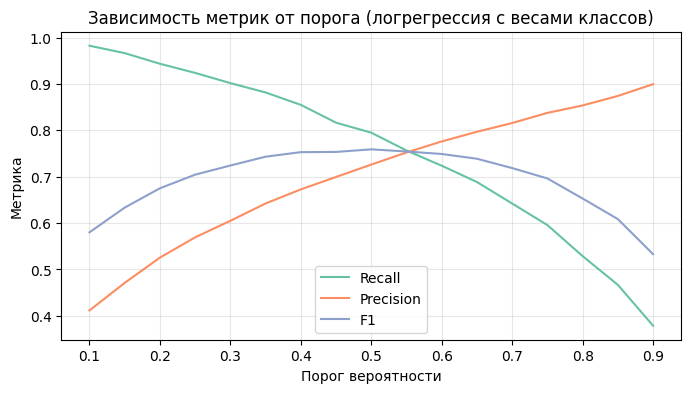

In [320]:
y_proba_combined = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for thr in thresholds:
    y_thr = (y_proba_combined >= thr).astype(int)
    recalls.append(recall_score(y_train, y_thr))
    precisions.append(precision_score(y_train, y_thr))
    f1s.append(f1_score(y_train, y_thr))

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Порог вероятности")
plt.ylabel("Метрика")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Зависимость метрик от порога (логрегрессия с весами классов)")
plt.show()

Выполним новый предикт с выбранным порогом. Хотим найти как можно больше тяжёлых пациентов, но при этом избежать слишком большого кол-ва ложноположительных.

In [321]:
THRESHOLD = 0.3

y_pred_combined_thr = (y_proba_combined >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_combined_thr))

Отчёт по классам (лучшая модель с порогом 0.3):
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3972
           1       0.60      0.90      0.72      2132

    accuracy                           0.76      6104
   macro avg       0.77      0.79      0.76      6104
weighted avg       0.82      0.76      0.77      6104



И "радикальный" вариант: попробуем не ошибаться с тяжёлыми пациентами вообще. Будем ловить много ложноположительных, но при этом какой-то процент пациентов мы смело можем относить к лёгкой стадии.

In [322]:
THRESHOLD = 0.1

y_pred_combined_thr = (y_proba_combined >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_combined_thr))

Отчёт по классам (лучшая модель с порогом 0.1):
              precision    recall  f1-score   support

           0       0.96      0.25      0.39      3972
           1       0.41      0.98      0.58      2132

    accuracy                           0.50      6104
   macro avg       0.69      0.61      0.49      6104
weighted avg       0.77      0.50      0.46      6104



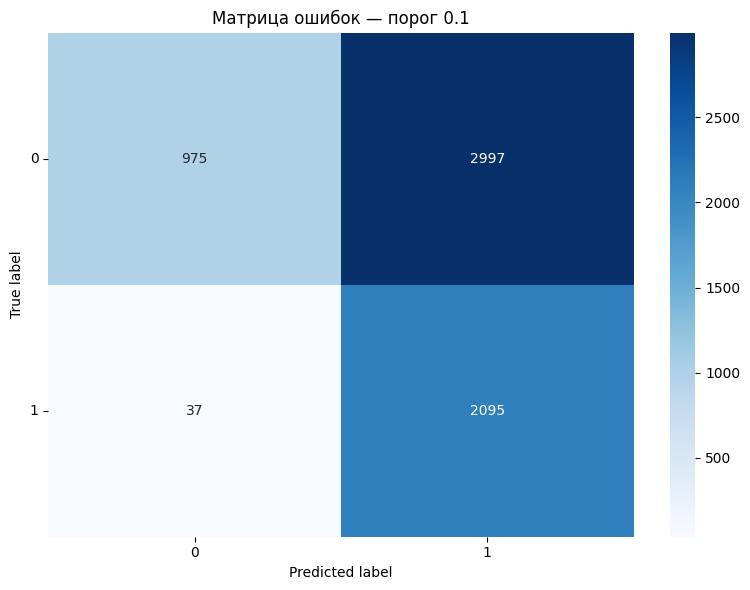

In [323]:
cm = confusion_matrix(y_train, y_pred_combined_thr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Матрица ошибок — порог {THRESHOLD}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

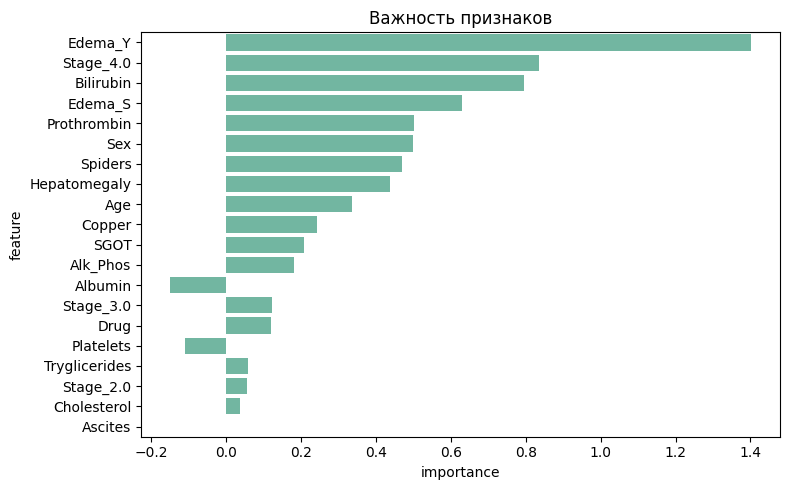

In [324]:
plot_feature_importances(gs_combined, model_step_name="logreg",
                         title="Важность признаков")

## 3. Feature Engineering

Попробуем сгенерировать дополнительные признаки, которые могут улучшить качество модели

### Обучаем модель

In [325]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

In [326]:
engineered_features = [
    "Symptom_Score",
    "Bilirubin_Albumin_Ratio",
    "Coagulation_Index",
    "Enzyme_Pattern"
]

preprocessor = make_preprocessor(
    strategy="log_clip_standard",
    engineered_features=engineered_features,
    engineered_strategy="standard"
)


In [327]:

fe_preprocessor = ImbPipeline([
    ("symptom_score", SymptomScoreTransformer()),
    ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
    ("coagulation_index", CoagulationIndexTransformer()),
    ("enzyme_pattern", EnzymePatternTransformer()),
    ("sampler", "passthrough"),
    ("preprocess", preprocessor),
])


decision_logreg_fe = Pipeline([
    ("preprocess", fe_preprocessor),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_combined = {
   "preprocess__sampler": [
        "passthrough",
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomOverSampler(random_state=RANDOM_STATE),
        SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
    ],
    'logreg__C': [0.01, 0.05, 0.1, 0.2, 0.3],
    'logreg__l1_ratio': [0.25, 0.5, 0.625, 0.75, 1],
    'logreg__penalty': ['elasticnet'],
    'logreg__solver': ['saga'],
    'logreg__class_weight': [None, 'balanced']
}

gs_combined_logreg_fe = GridSearchCV(
    decision_logreg_fe,
    param_grid=param_grid_combined,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

gs_combined_logreg_fe.fit(X_train, y_train)

print("\n" + "="*50)
print("Лучший результат общего пайплайна:")
print(f"Best params: {gs_combined.best_params_}")
print(f"Best Recall: {gs_combined.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Лучший результат общего пайплайна:
Best params: {'logreg__C': 0.2, 'logreg__class_weight': None, 'logreg__l1_ratio': 0.75, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga', 'sampler': RandomUnderSampler(random_state=42)}
Best Recall: 0.7950


c:\Users\aoesa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
750 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aoesa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aoesa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\aoesa\Ap

In [328]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

In [329]:
y_pred_combined_logreg_fe = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

Отчёт по классам (c features engineering):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



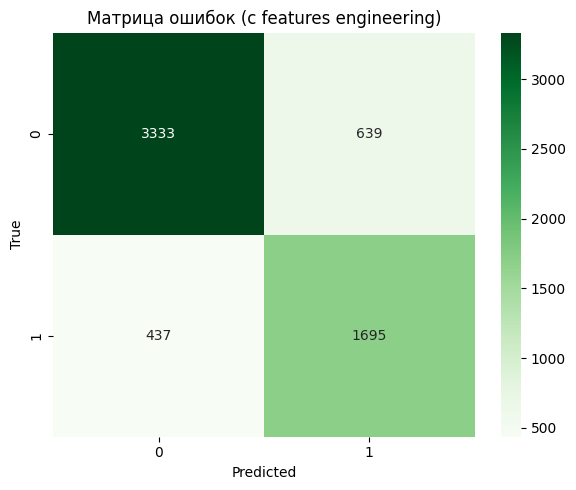

In [330]:
print(f"Отчёт по классам (c features engineering):")
print(classification_report(y_train, y_pred_combined_logreg_fe))

plot_confusion_matrix_simple(
    y_train,
    y_pred_combined_logreg_fe,
    title=f"Матрица ошибок (c features engineering)"
)

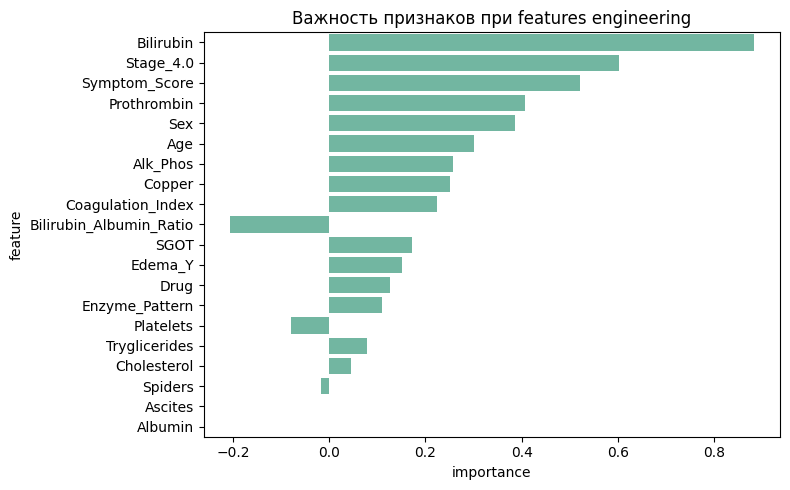

In [331]:
plot_feature_importances(gs_combined_logreg_fe, model_step_name="logreg",
                         title="Важность признаков при features engineering")

### Промежуточный вывод

Без feature engineering модель действительно опирается преимущественно на отдельные сильные клинические и лабораторные признаки (Edema, Stage_4.0, Bilirubin), при этом вклад коррелирующих показателей распределён неравномерно и часть признаков остаётся слабо интерпретируемой.

После feature engineering структура вклада признаков становится более упорядоченной: интегральные и производные показатели (Symptom_Score, Coagulation_Index, Bilirubin_Albumin_Ratio, Enzyme_Pattern) аккумулируют информацию из исходных переменных, что приводит к занулению или существенному ослаблению коэффициентов у части избыточных признаков. Это соответствует ожидаемому эффекту регуляризованной логистической регрессии при наличии информативных агрегатов.

Использование feature engineering в сочетании с повышением порога до 0.2 приводит к более сбалансированным метрикам между классами и росту F1-меры за счёт сокращения ложноположительных срабатываний при сохранении высокой чувствительности. Таким образом, модель демонстрирует более устойчивый и практически интерпретируемый компромисс между полнотой и точностью.

### Измерение порога

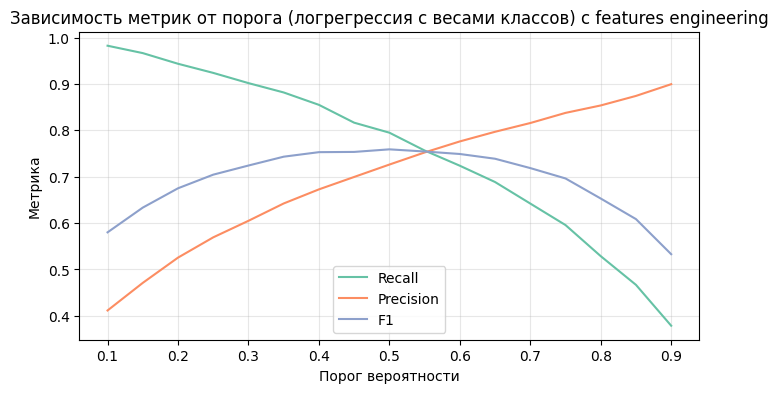

In [347]:
y_proba_combined_fe = cross_val_predict(
    gs_combined_logreg_fe.best_estimator_,
    X_train, y_train,
    cv=skf,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
recalls, precisions, f1s = [], [], []

for thr in thresholds:
    y_thr = (y_proba_combined >= thr).astype(int)
    recalls.append(recall_score(y_train, y_thr))
    precisions.append(precision_score(y_train, y_thr))
    f1s.append(f1_score(y_train, y_thr))

plt.figure(figsize=(8, 4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Порог вероятности")
plt.ylabel("Метрика")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Зависимость метрик от порога (логрегрессия с весами классов) с features engineering")
plt.show()

# Этап III. Проверка на тесте

Обучаем лучшую модель на всём трейне с выбранным порогом, строим график feature importances и делаем предикт для теста.

In [332]:
best_params = gs_combined_logreg_fe.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'logreg__C': 0.05, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga', 'preprocess__sampler': 'passthrough'}


In [333]:
final_pipeline = Pipeline([
    ("symptom_score", SymptomScoreTransformer()),
    ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
    ("coagulation_index", CoagulationIndexTransformer()),
    ("enzyme_pattern", EnzymePatternTransformer()),
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(
        random_state=RANDOM_STATE,
        penalty=best_params["logreg__penalty"],
        solver=best_params["logreg__solver"],
        class_weight=best_params["logreg__class_weight"],
        C=best_params["logreg__C"],
        l1_ratio=best_params["logreg__l1_ratio"],
        n_jobs=-1
    ))
])



# обучение на всём train
final_pipeline.fit(X_train, y_train)

,steps,"[('symptom_score', ...), ('bilirubin_albumin_ratio', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_skewed', ...), ('num_symmetric', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [335]:
y_test_proba  = final_pipeline.predict_proba(X_test)[:, 1]

In [336]:
rows = []

for thr in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    y_pred_thr = (y_test_proba >= thr).astype(int)

    rows.append({
        "threshold": thr,
        "recall": recall_score(y_test, y_pred_thr),
        "precision": precision_score(y_test, y_pred_thr),
        "f1": f1_score(y_test, y_pred_thr)
    })

pd.DataFrame(rows)

,threshold,recall,precision,f1
0,0.05,0.998124,0.359217,0.528302
1,0.10,0.983114,0.413902,0.582546
2,0.20,0.953096,0.512097,0.666230
3,0.30,0.902439,0.583738,0.708917
4,0.40,0.853659,0.651862,0.739236
5,0.50,0.799250,0.706468,0.750000


In [343]:
y_train_proba = final_pipeline.predict_proba(X_test)[:, 1]
THRESHOLD = 0.2

y_train_pred_02 = (y_train_proba >= THRESHOLD).astype(int)
y_test_pred_02  = (y_test_proba  >= THRESHOLD).astype(int)

Отчёт по классам (лучшая модель с порогом 0.2) c features engineering:
              precision    recall  f1-score   support

           0       0.95      0.51      0.67       993
           1       0.51      0.95      0.67       533

    accuracy                           0.67      1526
   macro avg       0.73      0.73      0.67      1526
weighted avg       0.80      0.67      0.67      1526



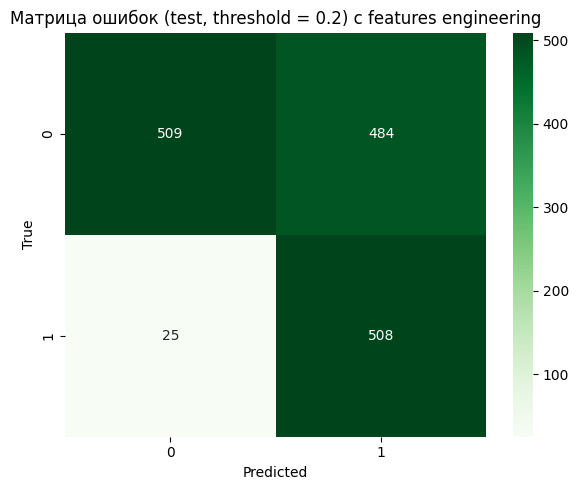

In [344]:
print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}) c features engineering:")
print(classification_report(y_test, y_test_pred_02))
plot_confusion_matrix_simple(
    y_test,
    y_test_pred_02,
    title=f"Матрица ошибок (test, threshold = {THRESHOLD}) c features engineering"
)

## Выводы

**Предобработка**

Оптимальной оказалась стратегия log → percentile clipping → StandardScaler для скошенных числовых признаков; бинарные признаки закодированы в 0/1, категориальные — через One-Hot Encoding. Добавление feature engineering (Symptom_Score, Coagulation_Index, Bilirubin_Albumin_Ratio, Enzyme_Pattern) привело к более компактному и интерпретируемому признаковому пространству, где часть исходных коррелирующих признаков получила нулевые или близкие к нулю коэффициенты.

**Моделирование**

Лучшие результаты показала логистическая регрессия с ElasticNet-регуляризацией и class_weight='balanced' без undersampling (sampler = passthrough). Оптимальный порог вероятности выбран равным 0.2, что соответствует компромиссу между высокой чувствительностью и приемлемой точностью.

**Результаты**

На тестовой выборке при пороге 0.2 модель достигает recall класса 1 ≈ 0.95, precision ≈ 0.51 и F1 ≈ 0.67, что подтверждается таблицей метрик и матрицей ошибок (25 FN против 508 TP).